<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [13]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Manifold Learning - Project 3D Geomerty Data to 2D

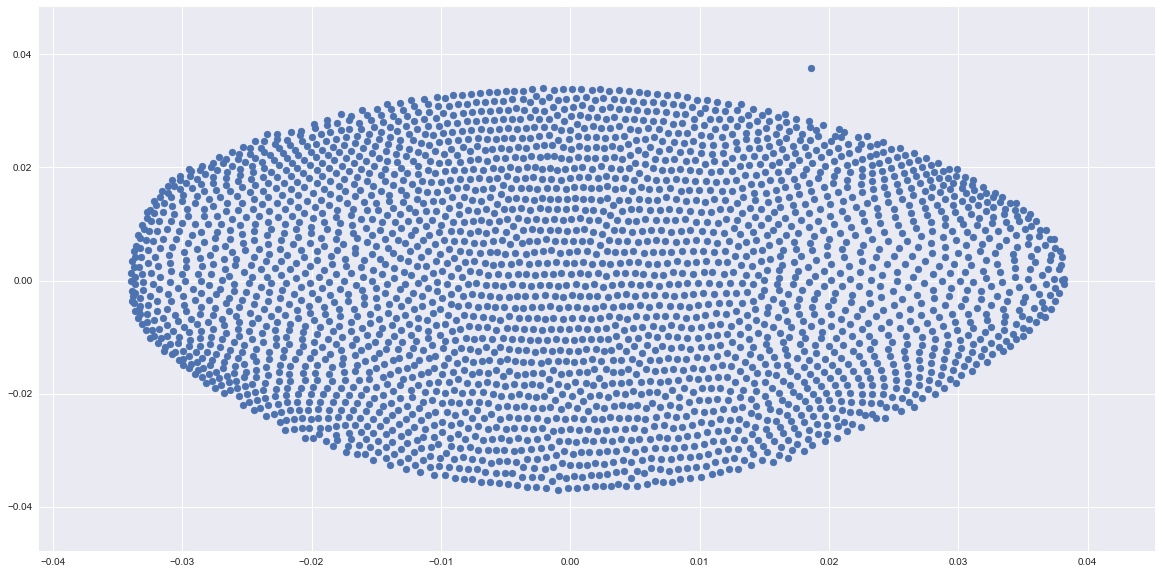

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.manifold import LocallyLinearEmbedding

geom = pd.read_csv('data\geometry.csv')
lle = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
out = lle.fit_transform(geom)
#np.shape(out.T)
#data1 = pd.DataFrame(out)
#geom['out'] = out.T

#colorize = dict(c=geom[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(out[:, 0], out[:, 1]) #, **colorize
#ax.set_ylim(0.15, -0.15);

#Model build
#Create train input array
#Model fit

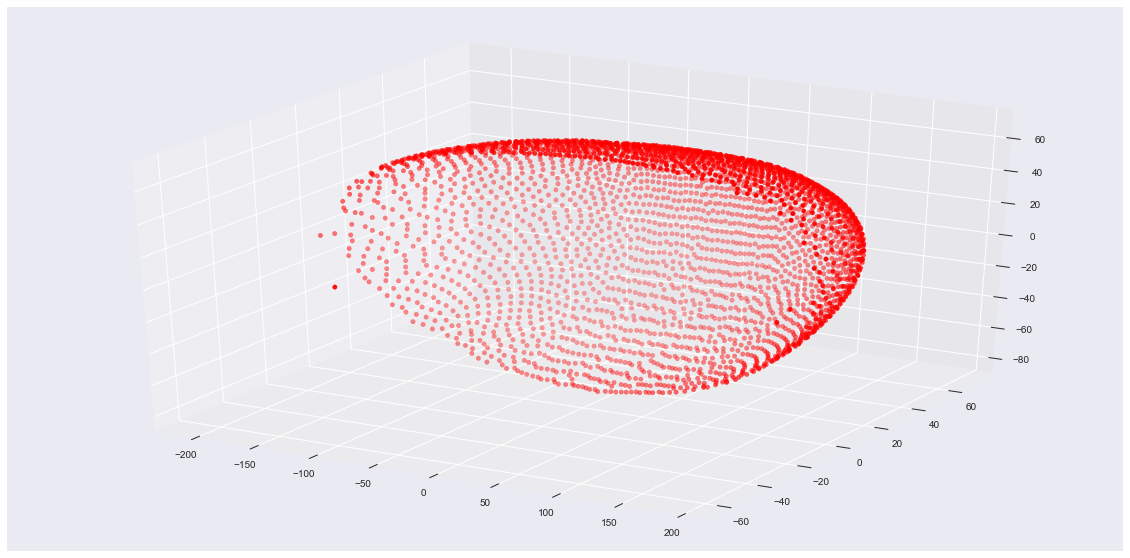

In [30]:
from mpl_toolkits.mplot3d import Axes3D

#colorize = dict(c=geom[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
#fig1, ax1 = plt.subplots()
#ax.scatter(, out[:, 1]) #, **colorize
#ax.set_ylim(0.15, -0.15);

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(geom.xcoord, geom.ycoord, geom.zcoord, c='r', marker='o')
plt.show()

# Try Using Gene2Function data - XGBoost

In [ ]:
"""
#Split NCBI data to in-situ genes and the rest.
ncbi = pd.read_csv('data/macro/NCBI.csv', encoding='ISO-8859-1')
ncbi1 = ncbi[ncbi.Genes.isin(set(list(b)))]
ncbi2 = ncbi[~ncbi.Genes.isin(set(list(b)))]
ncbi1.to_csv('data/macro/NCBI1.csv')
ncbi2.to_csv('data/macro/NCBI2.csv')

#Merge files from Gene2Functio
import os
import pandas as pd

data1 = pd.DataFrame()
for filename in os.listdir('data/gene2function1/'):
    #print(filename)
    file = pd.read_csv(f'data/gene2function1/{filename}', delimiter='\t')
    file = file.loc[file.Species == 'Fly']
    #merge_cols = list(set(list(data)) + set(list(file)))
    data1 = pd.concat([data1, file], axis=0, sort=False)
data1.set_index('NCBI  Gene ID', inplace=True)

data2 = pd.DataFrame()
for filename in os.listdir('data/gene2function2/'):
    #print(filename)
    file = pd.read_csv(f'data/gene2function2/{filename}', delimiter='\t')
    file = file.loc[file.Species == 'Fly']
    #merge_cols = list(set(list(data)) + set(list(file)))
    data2 = pd.concat([data2, file], axis=0, sort=False)
data2.set_index('NCBI  Gene ID', inplace=True)
data2.drop(['Symbol', 'Species'], axis=1, inplace=True)

data = pd.concat((data1, data2), axis=1)
data.to_csv('data/g2f.csv')
#data1.head()
#data.set_index('NCBI  Gene ID', inplace=True)
#data
"""

In [4]:
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

print(time.ctime(), 'Preprocess gene2function data')
data = pd.read_csv(f'data/other/g2f_scrape.csv', index_col=None)
data.drop(['NCBI  Gene ID'], inplace=True, axis=1)
#Remove trailing and ending spaces from column names and from Symbol column
data.rename(columns=lambda x: x.strip(), inplace=True)
data['Symbol'] = data.Symbol.apply(lambda x: x.strip())
data.fillna(0, inplace=True)
#Remove columns with only zeros or NAs.
#data = data.loc[:, ~(data==0).all(axis=0)]
#Remove columns with a very low sum
columns = list(data.columns)
columns.remove('Symbol')
#Make sure all types are float
data[columns] = data[columns].astype(float)
data.drop([col for col, val in data[columns].sum().iteritems() if val < 5], axis=1, inplace=True)
print(f'g2f_ shape ', data.shape)

#Gene to gene interactions: added as another 'function' of the gene (feature name is 'int'). Biogrid did not improve.
gg = pd.read_csv('data\\gg_interactions_flybase.csv', encoding='ISO-8859-1')
gg = gg.groupby(['Symbol']).sum().reset_index() # (Symbol, int)
data = data.merge(gg, on='Symbol', how='left')

#Make sure to rename 'na' to 'naa' and 'nan' to 'nana'
#data.rename(columns={'na':'naa', 'nan':'nana'}, inplace=True)
data.loc[data.Symbol == 'na', 'Symbol'] = 'naa'
data.loc[data.Symbol == 'nan', 'Symbol'] = 'nana'
#Join simliar columns
data.columns = [col.replace(".1", "") for col in data.columns]
data = data.groupby(data.columns, axis=1).sum().reset_index()
data.drop(['level_0'], axis=1, inplace=True)

data.to_csv('data/xgb_g2f_data.csv', index=False)

Sat Oct 27 13:51:38 2018 Create train input array
Add g2f_.csv  (4391, 1400)


In [16]:
import numpy as np
import pandas as pd
import time
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min

glist_20 = ['danr','CG14427','dan','CG43394','ImpL2','Nek2','CG8147','Ama','Btk29A','trn','numb','prd','brk','tsh','pxb','dpn','ftz','Kr','h','eve']
glist_60 = ['danr','CG14427','dan','CG43394','ImpL2','Nek2','CG8147','Ama','Btk29A','trn','numb','prd','brk','tsh','pxb','dpn','ftz','Kr','h','eve','Traf4','run','Blimp-1','lok','kni','tkv','MESR3','odd','noc','nub','Ilp4','aay','twi','bmm','hb','toc','rho','CG10479','gt','gk','apt','D','sna','NetA','Mdr49','fj','Mes2','CG11208','Doc2','bun','tll','Cyp310a1','Doc3','htl','Esp','bowl','oc','ImpE2','CG17724','fkh']

print(time.ctime(), 'Create train input array.')

geom = pd.read_csv('data/geometry.csv')
#Partition geometry file to 500 locations.
#Reduce geometry file to few centroids
#km = KMeans(n_clusters=200).fit(geom)
#Translate cluster to the closest points in geometry file.
#closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, geom)
#class_to_point = pd.DataFrame()
#class_to_point = pd.concat([class_to_point, pd.DataFrame(closest).T])

labels = pd.read_csv('data/labels.csv')
data_g2f = pd.read_csv('data/xgb_g2f_data.csv')
#Feature names
columns = list(data_g2f.columns)
columns.remove('Symbol')
data_g2f.drop([col for col, val in data_g2f[columns].sum().iteritems() if val < 100], axis=1, inplace=True)
#Feature names
columns = list(data_g2f.columns)
columns.remove('Symbol')

data_g2f = data[data.Symbol.isin(glist_60)]
data_g = pd.read_csv('data/bdtnp.csv')[data.Symbol]
#data_g = pd.read_csv('data/magic_dge.csv')[data.Symbol]

X = np.empty((len(data_g), len(columns)))
y = np.empty((3, len(data_g), 1))

for index, row in data_g.iterrows(): ##labels.iterrows():
    if(index % 100 == 0):
        print(index, ' ', end="")
    #Copy the values of a gene in data_g.
    factor = data_g.iloc[index][data_g2f.Symbol.values]
    #Multiply the gene to function matrix by factor. Sum over columns (genes) to move to 'function' space.
    #import pdb; pdb.set_trace()
    X[index] = data_g2f[columns].multiply(factor.values, axis='index').sum()
    #Select the geometry coordinate to learn.
    y[0][index] = geom.iloc[index][0]
    y[1][index] = geom.iloc[index][1]
    y[2][index] = geom.iloc[index][2]

X.shape #(1693, 82144 = 151 functions * 544 genes), (1693, 151), (1692, 160), (1693, 162), (1693, 179), (1693, 349), (1693, 629), (1693, 761), (1297, 1400)

Mon Nov 12 10:29:04 2018 Create train input array.
0  100  200  300  400  500  600  700  800  900  1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  2500  2600  2700  2800  2900  3000  

(3039, 96)

In [ ]:
#Parameter tunning
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as skm
from sklearn.grid_search import GridSearchCV


"""
params = {'max_depth':5,
          'learning_rate':0.01,
          'silent':True,
          'gamma':0.4,
          'min_child_weight':1,
          'max_delta_step':0,
          'subsample':0.6,
          'colsample_bytree':0.9,
          'colsample_bylevel':1,
          'reg_alpha':1e-05,
          'reg_lambda':0,
          'scale_pos_weight':1,
          'objective': 'reg:linear',
          'missing':None}
xgtrain = xgboost.DMatrix(X, label=y)
cvresult = xgboost.cv(params, xgtrain, num_boost_round=2000, nfold=5, metrics='rmse', early_stopping_rounds=50)
print(f'cvresult: {cvresult.shape[0]}')
#cvresult: 591, 1615, 724
"""

param_test1 = {
 'max_depth': [3,5,7,11] #, 'min_child_weight': [1,3,5]
}
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(
    estimator = XGBRegressor(learning_rate = 0.01,
                              n_estimators=591,
                              #max_depth=5,
                              min_child_weight=1,
                              max_delta_step=0,
                              gamma=0.4,
                              subsample=0.6,
                              colsample_bytree=0.9,
                              colsample_bylevel=1,
                              objective= 'reg:linear',
                              reg_alpha=1e-05,
                              reg_lambda=0,
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27), 
                param_grid = param_test1,
                scoring='neg_mean_squared_error',
                #n_jobs=4,
                iid=False,
                cv=5)

print(time.ctime(), 'Fit model...')
gsearch1.fit(X, y)
print(gsearch1.grid_scores_, '\nBest params: ', gsearch1.best_params_, '\nBest score: ', gsearch1.best_score_)
#{'max_depth': 5, 'min_child_weight': 1} -2874.782086261991 {'gamma': 0.4} -2873.0005245122356 {'colsample_bytree': 0.9, 'subsample': 0.6} -2848.103469994282 {'reg_alpha': 1e-05} -2844.687961860015

In [ ]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as skm

#model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7), n_estimators=400)
#xgb = XGBRegressor(max_depth=10, learning_rate=0.01, n_estimators=401, gamma=0, min_child_weight=5, max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=1e0, reg_lambda=0, scale_pos_weight=1)
model = [None, None, None]

for coordinate in [0, 1, 2]:
    X_train, X_test, y_train, y_test = train_test_split(X, y[coordinate], test_size = 0.1, random_state = 4)
    model[coordinate] = XGBRegressor( learning_rate = 0.01,
                          n_estimators=724,
                          max_depth=5,
                          min_child_weight=1,
                          max_delta_step=0,
                          gamma=0.4,
                          subsample=0.6,
                          colsample_bytree=0.9,
                          colsample_bylevel=1,
                          objective= 'reg:linear',
                          #objective='binary:logistic',
                          reg_alpha=1e-05,
                          reg_lambda=0,
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27,
                          silent=True,
                          #objective=mape
                         )
    print(time.ctime(), f'Fit model {coordinate}...')
    model[coordinate].fit(X_train, np.asarray(y_train), eval_metric='rmse')
    #model.fit(X_train, y_train, eval_metric='auc', verbose=True, eval_set=[(X_test, y_test)], early_stopping_rounds=100)

    print(time.ctime(), f'Model {coordinate} predict')
    y_pred = model[coordinate].predict(X_test)
    #y_pro = model.predict_proba(X_test)[:, 1]
    #print ("AUC Score : %f" % metrics.roc_auc_score(test_label, y_pro))
    #print ("Accuracy : %.4g" % metrics.accuracy_score(test_label, y_pred))
    #model.save_model('data/xgb_model.h5')
    r2 = skm.r2_score(y_test, y_pred)
    mae = skm.mean_absolute_error(y_test, y_pred)
    mse = skm.mean_squared_error(y_test, y_pred)
    print(time.ctime(), 'R^2: ' + str("%.3f" % r2) + ' MAE: ' + str("%.3f" % mae) + ' MSE: ' + str("%.3f" % mse))


#Use the models
#dge = pd.read_csv('data/dge_binarized_distMap.csv').T[data.Symbol].reset_index(drop=True)
dge = pd.read_csv('data/magic_dge.csv')[data.Symbol]
#dge = pd.read_csv('data/scimpute.csv')[data.Symbol]
submit = pd.DataFrame()
for index, row in dge.iterrows(): ##labels.iterrows():
    if(index % 100 == 0):
        print(index, ' ', end="")
    factor = dge.iloc[index]
    #Multiply the gene to function matrix by factor. Sum over columns (genes) to move to 'function' space.
    X_pred = data[columns].multiply(factor.values, axis='index').sum()
    y0 = model[0].predict(X_pred)[0]
    y1 = model[1].predict(X_pred)[0]
    y2 = model[2].predict(X_pred)[0]
    print(y0, y1, y2)
    closest, _ = pairwise_distances_argmin_min(np.array([y0, y1, y2]).reshape(1, -1), geom) # columns=(0,1,2), -181.105000, 34.445000, 16.350000
    submit = pd.concat([submit, pd.DataFrame(closest).T])

"""
%matplotlib inline
import seaborn as sns
#sns.set(font_scale = 1.5)
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model)
pyplot.show()
importances = model.feature_importances_
importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(columns)})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (28,28), color = 'orange')

#model.get_booster().get_score(importance_type='weight') 
importance_frame.to_csv('importance.csv')
"""

- Sun Oct 21 17:29:39 2018 R^2: 0.594 MAE: 34.651 MSE: 2610.784
- Sun Oct 21 20:15:01 2018 R^2: 0.604 MAE: 38.248 MSE: 2735.212
- Sun Oct 21 20:32:13 2018 R^2: 0.628 MAE: 39.013 MSE: 2750.446
- Mon Oct 22 10:51:35 2018 R^2: 0.611 MAE: 39.749 MSE: 2838.655
- Mon Oct 22 11:17:26 2018 R^2: 0.632 MAE: 38.332 MSE: 2659.526 gene to gene interaction Flybase.
- Tue Oct 23 16:00:01 2018 R^2: 0.657 MAE: 34.798 MSE: 2376.744
- Tue Oct 23 16:18:40 2018 R^2: 0.688 MAE: 31.221 MSE: 2276.805
- Tue Oct 23 16:45:23 2018 R^2: 0.657 MAE: 31.397 MSE: 2259.849
- Wed Oct 24 11:27:15 2018 R^2: 0.687 MAE: 31.327 MSE: 2046.096
- Wed Oct 24 11:33:50 2018 R^2: 0.690 MAE: 32.464 MSE: 2161.590
- Thu Oct 25 09:20:45 2018 R^2: 0.694 MAE: 31.522 MSE: 2041.968
- Sun Nov  4 23:56:42 2018 R^2: 0.717 MAE: 31.136 MSE: 1876.040

In [130]:
#np.concatenate((y_test, y_pred))
[(y_test[i], y_pred[i]) for i in range(0,130)]

[(array([-44.19]), 30.540089),
 (array([-127.79]), -130.77412),
 (array([-55.34]), 2.3030593),
 (array([-128.78]), -117.977165),
 (array([-108.43]), -124.75562),
 (array([-19.65]), -42.54191),
 (array([152.28]), 43.381638),
 (array([-50.68]), -11.9283285),
 (array([-194.04]), -156.17659),
 (array([-35.38]), -11.854646),
 (array([-79.26]), -87.66902),
 (array([-79.28]), -29.691292),
 (array([-15.18]), -20.640968),
 (array([-15.71]), -58.87374),
 (array([-25.66]), -21.86433),
 (array([-137.18]), -166.09978),
 (array([-23.61]), -19.312868),
 (array([-35.79]), -28.80743),
 (array([-36.53]), -28.076221),
 (array([-35.63]), -57.375675),
 (array([132.38]), 95.47679),
 (array([148.16]), 88.99835),
 (array([26.95]), -11.397624),
 (array([138.26]), -1.6106586),
 (array([-74.88]), -13.188385),
 (array([-28.92]), -20.93518),
 (array([-74.88]), -20.858892),
 (array([-65.44]), -48.881847),
 (array([-152.63]), -136.53082),
 (array([120.72]), -30.990812),
 (array([64.66]), -10.832377),
 (array([26.77]

## Handle multi target - RandomForest

In [2]:
import pandas as pd
from random import randint, sample
labels = pd.read_csv('data/labels.csv', index_col=0)
labels['num_nulls'] = labels.isnull().sum(axis=1)

#Recalculate the label file.
#Maximum locations for a cell in the label file is 6. We need to evenely distribute these values to 10 locations.
results = pd.DataFrame(columns=['loc1', 'loc2', 'loc3', 'loc4', 'loc5', 'loc6', 'loc7', 'loc8', 'loc9', 'loc10'])
for index, row in labels.iterrows():
    if(row.num_nulls == 0):
        i = sample(range(1,7), 4)
        row['loc7'] = i[0]
        row['loc8'] = i[1]
        row['loc9'] = i[2]
        row['loc10'] = i[3]
    #Only one NA.
    elif(row.num_nulls == 1):
        row['loc6'] = row.loc1
        row['loc7'] = row.loc2
        row['loc8'] = row.loc3
        row['loc9'] = row.loc4
        row['loc10'] = row.loc5
    elif(row.num_nulls == 2):
        i1 = randint(1,2)
        i2 = randint(3,4)
        row['loc5'] = row[f'loc{i1}']
        row['loc6'] = row[f'loc{i2}']
        row['loc7'] = row.loc1
        row['loc8'] = row.loc2
        row['loc9'] = row.loc3
        row['loc10'] = row.loc4
    elif(row.num_nulls == 3):
        i = randint(1,3)
        row['loc4'] = row['loc7'] = row.loc1
        row['loc5'] = row['loc8'] = row.loc2
        row['loc6'] = row['loc9'] = row.loc3
        row['loc10'] = row[f'loc{i}']
    elif(row.num_nulls == 4):
        row['loc3'] = row['loc5'] = row['loc7'] = row['loc9'] = row.loc1
        row['loc4'] = row['loc6'] = row['loc8'] = row['loc10'] = row.loc2
    elif(row.num_nulls == 5):
        row['loc2'] = row['loc3'] = row['loc4'] = row['loc5'] = row['loc6'] = row['loc7'] = row['loc8'] = row['loc9'] = row['loc10'] = row.loc1
    results = results.append(row)

results = results + 1
results.to_csv('data/labels_multiple.csv')

In [11]:
import time
import numpy as np

#This model is run three times, one for each coordindate. (x=0, y=1, z=2).
coordinate=2
print(time.ctime(), 'Create train input array')

results = pd.read_csv('data/labels_multiple.csv')
geom = pd.read_csv('data/geometry.csv')
g2f = pd.read_csv('data/xgb_g2f_data.csv')
X = np.empty((len(results), len(g2f.columns)-1 ))
y = np.empty((len(results), 10))
columns = list(g2f.columns)
columns.remove('Symbol')

for index, row in results.iterrows():
    try:
        if(index % 100 == 0):
            print(index, ' ', end="")
        #Copy the values of the collected genes for the specific cell in d.
        factor = d.iloc[index][g2f.Symbol.values]
        #Multiply the gene to function matrix by factor and sum over columns to move to 'function' space.
        #import pdb; pdb.set_trace()
        X[index] = g2f[columns].multiply(factor.values, axis='index').sum()
        #Select the geometry coordinate to learn.
        y[index] = [geom.iloc[int(row[f'loc{i}'])][coordinate] for i in range(1,11)]
    except:
        print('Exception in train.............', row)

X.shape #(1693, 82144 = 151 functions * 544 genes)
        #(1297, 761) y.shape = (1297, 10)

Sat Oct 27 14:38:06 2018 Create train input array
0  100  200  300  400  500  600  700  800  900  1000  1100  1200  

(1297, 1400)

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.ensemble import RandomForestRegressor

coordinate = 2 #The same as in the previous cell.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Fit regression model
#model = DecisionTreeRegressor(max_depth=5)
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=200)
model.fit(X_train, y_train)
#model.save_model('data/xgb_model.h5')

y_pred = model.predict(X_test)
r2 = skm.r2_score(y_test, y_pred)
#From SKLearn mean_absolute_error documentation:
#If multioutput is ‘raw_values’, then mean absolute error is returned for each output separately.
#If multioutput is ‘uniform_average’ (default) or an ndarray of weights, then the weighted average of all output errors is returned.
mae = skm.mean_absolute_error(y_test, y_pred)
mse = skm.mean_squared_error(y_test, y_pred)
print(time.ctime(), 'R^2: ' + str("%.3f" % r2) + ' MAE: ' + str("%.3f" % mae) + ' MSE: ' + str("%.3f" % mse))
pd.DataFrame(model.predict(X)).to_csv(f'data/xgb_{coordinate}.csv')

Sat Oct 27 14:43:01 2018 R^2: 0.792 MAE: 15.843 MSE: 520.479


- Thu Oct 25 13:59:33 2018 R^2: 0.706 MAE: 9.671 MSE: 155.967
- Thu Oct 25 14:02:50 2018 R^2: 0.739 MAE: 9.185 MSE: 140.356
- Sat Oct 27 14:37:20 2018 R^2: 0.713 MAE: 8.902 MSE: 152.944 xgb_1
- Sat Oct 27 14:43:01 2018 R^2: 0.792 MAE: 15.843 MSE: 520.479 xgb_2

## Select the best 10 points from outputs of the models

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

num_situ = 60
#ann = pd.read_csv(f'data/ann_{num_situ}.csv') #i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
ann = pd.read_csv('data/maxmcc_60_10_selected_plus_1.csv')
#Translate indices to coordinates: geom.iloc[ann_10.iloc[0]] (xcoord, ycoord, zcoord)
xgb_x = pd.read_csv('data/xgb_0.csv') #Each row has 10 candidates for coordinate.
xgb_y = pd.read_csv('data/xgb_1.csv')
xgb_z = pd.read_csv('data/xgb_2.csv')
geom = pd.read_csv('data/geometry.csv')

submit = pd.DataFrame()
for i in range(0,3039):
    if(i % 100 == 0):
        print(i, ' ', end="")
    #Combine three coordinate rows to one dataframe with 10 rows
    xg = pd.DataFrame({'xcoord': xgb_x.iloc[i], 'ycoord': xgb_y.iloc[i], 'zcoord': xgb_z.iloc[i]})
    #Join the ten rows that are results from ann model.
    len_list = np.count_nonzero(~np.isnan(ann.iloc[i]))
    xg = pd.concat([xg, geom.iloc[ann.iloc[i,0:len_list].values]]) #xcoord,ycoord,zcoord
    #Search for ten clusters
    km = KMeans(n_clusters=10).fit(xg)
    #Translate to the closest points in geometry file.
    closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, geom) # columns=(0,1,2), -181.105000, 34.445000, 16.350000
    submit = pd.concat([submit, pd.DataFrame(closest).T])

#submit = submit + 1
#submit.to_csv(f'submit_{num_situ}.csv')

In [12]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

submit = pd.DataFrame()
geom = pd.read_csv('data/geometry.csv')
xg = pd.DataFrame(columns=['xcoord', 'ycoord', 'zcoord'])
xg = pd.concat([xg, geom.iloc[[1369, 1370, 1407, 1445, 1558, 2950, 3019, 2974, 1682, 1684]]]) # 1253,1287,1324,1590,1591,2942,2943

#Search for ten clusters
#km = AgglomerativeClustering(n_clusters=6).fit(xg)
km = KMeans(n_clusters=7).fit(xg)
#Translate to the closest points in geometry file.
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, geom) # columns=(0,1,2), -181.105000, 34.445000, 16.350000
submit = pd.concat([submit, pd.DataFrame(closest).T])
submit

,0,1,2,3,4,5,6
0,1558,1684,2950,1407,2974,3019,1682
